<div class="alert alert-block alert-info">
    
### Deploy the Model

#### 0. Setup the imports, bucket and model reference
#### 1. Setup the path to the model
#### 2. Deploy the model
#### 3. Setup and Prepare the data for testing
#### 4. Execute endpoint with the test data
#### 5. Cost Analysis - Evaluate the model based on cost
#### 6. Evaluate standard metrics used for **Binary Classification**
    
</div>

In [152]:
# At this point the model artefacts MUST be available in an S3 bucket

import numpy as np
import pandas as pd
import boto3
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
import sagemaker.amazon.common as smac
import sagemaker
from sagemaker.predictor import csv_serializer, json_deserializer
import matplotlib.pyplot as plt

# Sagemaker Session
sess = sagemaker.session.Session()

# Setup the execution role - IGNORE THE WARNING
role = get_execution_role()

<div class="alert alert-block alert-success">
    
### 1. Setup the path to the Model
* Setup the bucket name
* Ensure the model folder is correct - you may get the name from console or from S3
    
**Specifying an incorrect path | model will lead to an Error!!**

</div>

In [153]:
# CHANGE the bucket name
bucket = 'awsrajeev'

# Confirm this
prefix = "sagemaker/churn-analysis/output"

# MUST CHANGE THIS - Model Artefacts folder 
specific_model="xgboost-my-training-job-101-2020-05-14-10-42-07-285"

s3_model_artefacts="s3://{}/{}/{}/output/model.tar.gz".format(bucket, prefix,specific_model)
s3_model_artefacts

's3://awsrajeev/sagemaker/churn-analysis/output/xgboost-my-training-job-101-2020-05-14-10-42-07-285/output/model.tar.gz'

<div class="alert alert-block alert-success">
    
### 2. Deploy the Model as endpoint
* The endpoint is launched in a container
* Endpoint exposes a REST API that responds with CSV/JSON depending on algo and setup
* Implemeneted in a Docker container and hosted on EC2

<code style="background:yellow;color:black">Endpoint setup takes a few minutes, so go for a quick break!!!</code>
    
<code style="background:red;color:white">Endpoint name MUST be unique - so if you try to re install it will fail!!</code>
    
</div>

In [ ]:
# This is the name of the endpoint
endpoint_name="churn-endpoint"

# Get the model container
container = get_image_uri(boto3.Session().region_name,
                          'xgboost', 
                          repo_version='0.90-2'); 

model = sagemaker.model.Model(model_data=s3_model_artefacts, image=container, role=role, sagemaker_session=sess )
model.deploy(initial_instance_count=1,instance_type="ml.c4.2xlarge", endpoint_name=endpoint_name)

<div class="alert alert-block alert-success">
    
### 3. Setup and Prepare the data for testing
    
#### Setup the Data
    
* The test data was generated as part of the data prep. For convenience its available in the local folder
* The test data we will use is in th elocal file  *test_header.csv*
    * The first column is the label column - it is the actual value *(1 = Churned, 0 = Not Churned)*
    * Check out the *One Hot Encoded* State_ Columns !!!
    * In all 70 columns
* We will read the data into memory (data frame)
* Open the test_header.csv to see the raw data
</div>

In [155]:
df = pd.read_csv('test_header.csv')
df.columns

Index(['Churn?_True.', 'Account Length', 'VMail Message', 'Day Mins',
       'Day Calls', 'Eve Mins', 'Eve Calls', 'Night Mins', 'Night Calls',
       'Intl Mins', 'Intl Calls', 'CustServ Calls', 'State_AK', 'State_AL',
       'State_AR', 'State_AZ', 'State_CA', 'State_CO', 'State_CT', 'State_DC',
       'State_DE', 'State_FL', 'State_GA', 'State_HI', 'State_IA', 'State_ID',
       'State_IL', 'State_IN', 'State_KS', 'State_KY', 'State_LA', 'State_MA',
       'State_MD', 'State_ME', 'State_MI', 'State_MN', 'State_MO', 'State_MS',
       'State_MT', 'State_NC', 'State_ND', 'State_NE', 'State_NH', 'State_NJ',
       'State_NM', 'State_NV', 'State_NY', 'State_OH', 'State_OK', 'State_OR',
       'State_PA', 'State_RI', 'State_SC', 'State_SD', 'State_TN', 'State_TX',
       'State_UT', 'State_VA', 'State_VT', 'State_WA', 'State_WI', 'State_WV',
       'State_WY', 'Area Code_408', 'Area Code_415', 'Area Code_510',
       'Int'l Plan_no', 'Int'l Plan_yes', 'VMail Plan_no', 'VMail Plan_yes'],


<div class="alert alert-block alert-info">
    
#### Prepare the data for testing
    
1. Move the label to the end and name it "Actual"
2. Create a new column in the dataframe and call it "Predicted"

</div>

In [156]:
#1. Move the label column
df_churn = df['Churn?_True.']
df = pd.concat( [df.drop(['Churn?_True.'], axis=1), df_churn], axis=1)

#2. Create a new column at the end - call it predicted
count = len(df) 
df_predicted = pd.Series(-1.0,range(0,count - 1),name="Predicted")
df = pd.concat( [df, df_predicted], axis=1)

<div class="alert alert-block alert-success">
    
###  4. Execute endpoint with the test data

Execute prediction using [API](https://sagemaker.readthedocs.io/en/stable/predictors.html)
    
1. Setup the predictor object
2. In a loop run the test using the data from the file
    * Add the predicted value under the column 'Predicted'
3. Add the received prediction in the test data frame
    
<br>
    


</div>

In [157]:
# At this time you endpoint MUST be up
predictor = sagemaker.predictor.RealTimePredictor(endpoint=endpoint_name, sagemaker_session=sess)

predictor.content_type = 'text/csv'
predictor.serializer = csv_serializer
predictor.deserializer = json_deserializer
predictor.accept = 'text/csv'

for i in range(len(df)) :
    predicted_churn = predictor.predict(test_features[i])
    
    # Set the predicted value - probability of churn
    df.loc[i, 'Predicted']=predicted_churn

# Used in the analysis
test_features = np.array(df.drop(['Churn?_True.',"Predicted"], axis=1).values).astype('float32')
    

<div class="alert alert-block alert-success">
    
### 5. Cost Analysis - Evaluate the model based on cost
Business has to pay a price for the *FP* and *FN*. E.g., if a customer who is going to churn is incorrectly predicted as NOT churn then company will lose the customer!! Here is a simple analysis.    
    
1. If Customer is NOT going to churn = TN = cost to Atizen = USD 0<br>
2. If Customer is LOST then Aitzen will lose = FN = USD 1000 per annum<br>
3. If Customer is about to Churn BUT Atizen offered Promotion = TP = USD 100 per annum<br>
4. If Customer is NOT going to Churn BUT Atizen offered Promotion = FP = USD 1000 per annum
    
    * <code style="background:yellow;color:black">Cost Incurred by Aitzen</code>= TN * 0 + FN * 1000 + TP * 100 + FP * 1000

<br>
    
#### Churn Factor
Predictor return a probabilty not an absolute 0 or 1. You need to decide whether predicted value = 0.5 represents a customer that is going to churn or NOT!!! Sensitivity of the model is controlled by adjusting this factor. No hard and fast rule but try out multiple values to <code style="background:yellow;color:black">MINIMIZE the cost</code>.
    
</div>

In [ ]:
# Function that calculates the cost based on churn_factor
def calculate_confusion_matrix_and_cost(churn_factor):
    TP = 0
    TN = 0
    FP = 0
    FN = 0

    # ADJUST this for making changes for cost
    # FN & FP depends on this custoff
#     churn_cutoff = 0.8

    for i in range(len(df)) :

        predicted_churn = df.iloc[i]['Predicted']

        if (predicted_churn > churn_factor):
            predicted_churn=1
        else:
            predicted_churn=0

        # Set the values of TN & FP
        if (df.iloc[i]['Churn?_True.'] == 0.0) :
            if (predicted_churn == 0.0) :
                # Actual -ve    Predicted  -ve
                TN += 1
            else:
                # Actual -ve    Predicted  +ve
                 FP += 1

        # Set the values of TP and FN
        if (df.iloc[i]["Churn?_True."] == 1.0):
            if (predicted_churn == 1.0 ) :
                # Actual +ve    Predicted  +ve
                TP += 1
            else:
                # Actual +ve    Predicted  -ve
                FN += 1

    # Setup the confusion matrix
#     confusion_matrix = pd.DataFrame(index =['predicted_true', 'predicted_false']) 
#     confusion_matrix.loc['predicted_true', 'actual_true'] = 'TP='+str(TP)
#     confusion_matrix.loc['predicted_true', 'actual_false'] = 'FP='+str(FP)
#     confusion_matrix.loc['predicted_false', 'actual_true'] = 'FN='+str(FN)
#     confusion_matrix.loc['predicted_false', 'actual_false'] = 'TN='+str(TN)
    
    confusion_matrix = pd.DataFrame(index =['predicted_true', 'predicted_false']) 
    confusion_matrix.loc['predicted_true', 'actual_true'] = TP
    confusion_matrix.loc['predicted_true', 'actual_false'] = FP
    confusion_matrix.loc['predicted_false', 'actual_true'] = FN
    confusion_matrix.loc['predicted_false', 'actual_false'] = TN
#     display(confusion_matrix)

    # Cost 
    cost =  TN * 0 + FN * 1000 + TP * 100 + FP * 1000
#     display("Cost = $"+str(cost))
    
    return cost, confusion_matrix
    
# Execute with churn factor = 0.5
calculate_confusion_matrix_and_cost(0.5)

<div class="alert alert-block alert-info">
    
### Automate the Cost Analysis
* By executing the above function multiple times with different churn_factor values.
* Plot them on a graph
    
</div>

- - - - - - - - !


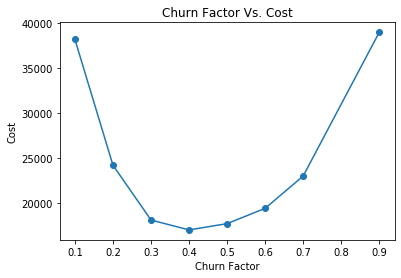

In [171]:
# Run the cost analysis 10 times
cutoffs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.9]

# USE this for larger number of rus *BUT* it would take time
# cutoffs = np.arange(0.01, 1, 0.01)

# Create a datafram to hold the churn factor & cost
analysis_df=pd.DataFrame(columns=['churn_factor', 'cost']) 
i=0
for c in cutoffs:
    print("-",end=" ")
    analysis_df.loc[i, 'churn_factor']=c
    cost, cm = calculate_confusion_matrix_and_cost(c)
    analysis_df.loc[i, 'cost']=cost
    i += 1
print("!")

# Lets plot a chart
%matplotlib inline
plt.plot(analysis_df['churn_factor'],analysis_df['cost'], marker='o')
plt.xlabel('Churn Factor')
plt.ylabel('Cost')
plt.title('Churn Factor Vs. Cost')
plt.show()

<div class="alert alert-block alert-success">
    
### 6. Evaluate standard metrics used for **Binary Classification**

* <code style="background:yellow;color:black">Accuracy </code> =  (TP + TN) / (TN + FP + TP + FN)
   <br> An accuracy of 1 *may* indicate that the model is overfitting.
    
* <code style="background:yellow;color:black">Precision</code> = TP / (TP + FP) 
    <br> Percentage of correctly predictive positive values <br>

* <code style="background:yellow;color:black">Sensitivity</code> = TP / (TP + FN)
    * Also referred to as *Recall*
    * Also referred to as *True Positive Recall*
    * High sensitivity desired when cost of FN is HIGH e.g., predicting "Not Fraud" for "Actual Fraud"
      <br> To increase sensitivity - reduce FN which *may* increase FP

    
* <code style="background:yellow;color:black">Specificity</code> = TN / (TN + FP)
    * Also referred to as *True Negative Rate*
    * High specificity desired when cost of FP is HIGH e.g., marking an email as spam
    * *False Positive Rate* = (1 - Specificity) <br>

    
* <code style="background:yellow;color:black">F1 Score</code> = 2 * (Precision * Recall) / (Precision + Recall)
    <br> Harmonic Average of *Specificity* and *Sensitivity*
</div>

In [189]:
# Set this to the BEST churn factor value
cutoff = 0.4

# Confusion matrix
cost, c_matrix = calculate_confusion_matrix_and_cost(cutoff)

# Get the confusion matrix elements
TP = c_matrix.loc['predicted_true', 'actual_true']
FP = c_matrix.loc['predicted_true', 'actual_false']
FN = c_matrix.loc['predicted_false', 'actual_true']
TN = c_matrix.loc['predicted_false', 'actual_false']

metrics_df=pd.DataFrame(index=["accuracy","precision","recall","specificity","f1 score" ],columns=['metric']) 

# Accuracy
metrics_df.loc['accuracy', 'metric'] = (TN + TP)/(TP + TN + FP + FN)

# Precision
metrics_df.loc['precision', 'metric']  = TP / (TP + FP)

# Recall
metrics_df.loc['recall', 'metric']  = TP / (TP + FN)


# Specificity 
metrics_df.loc['specificity', 'metric'] = TN / (TN + FP)

# F1 Score
metrics_df.loc['f1 score', 'metric'] = 2 * (precision * recall) / ( precision)

# Display the metrics
metrics_df

,metric
accuracy,0.961078
precision,0.888889
recall,0.833333
specificity,0.982517
f1 score,1.66667
